# Airbnb Listings — Data Cleaning Pipeline (with Audit + Visual QA)

This notebook:
- Loads raw `Listings.csv`
- Cleans text (mojibake repair)
- Converts data types + parses % fields
- Handles missing values + feature engineering
- Produces **two outputs**:
  1) `listings_cleaned_with_workings.csv` (audit/workings)
  2) `listings_final.csv` (analysis-ready)
- Produces visual QA during the run (missingness, rule impact, examples)

## Importing Libraries

In [1]:
import re
import unicodedata

import pandas as pd
import ftfy

import matplotlib.pyplot as plt
from IPython.display import display

print("Libraries imported.")


Libraries imported.


## Visual + Logging Helpers

In [2]:
clean_log = []
rule_counts = {}

def log_rule(rule, column, affected, notes=""):
    clean_log.append({
        "rule": rule,
        "column": column,
        "rows_affected": int(affected),
        "notes": notes
    })
    rule_counts[rule] = rule_counts.get(rule, 0) + int(affected)
    display(pd.DataFrame(clean_log))

def show_changes(df, raw_col, clean_col, n=10, seed=42):
    if raw_col not in df.columns or clean_col not in df.columns:
        print(f"Cannot show changes: missing {raw_col} or {clean_col}")
        return
    mask = df[raw_col].fillna("").astype(str) != df[clean_col].fillna("").astype(str)
    if mask.sum() == 0:
        print(f"No changes detected between {raw_col} and {clean_col}.")
        return
    ex = df.loc[mask, [raw_col, clean_col]].sample(min(n, int(mask.sum())), random_state=seed)
    display(ex)

def plot_top_missing(df, top_n=20, title="Top columns by % missing"):
    missing = df.isna().mean().sort_values(ascending=False).head(top_n) * 100
    plt.figure(figsize=(10, 5))
    missing.plot(kind="bar")
    plt.title(title)
    plt.ylabel("% missing")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    plt.show()

def plot_rule_counts(rule_counts, title="Rows affected by each cleaning rule"):
    if not rule_counts:
        print("No rules logged yet.")
        return
    s = pd.Series(rule_counts).sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    s.plot(kind="bar")
    plt.title(title)
    plt.ylabel("Rows affected")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

def column_profile(df, cols):
    out = []
    for c in cols:
        if c not in df.columns:
            continue
        out.append({
            "column": c,
            "dtype": str(df[c].dtype),
            "missing": int(df[c].isna().sum()),
            "missing_%": float(df[c].isna().mean() * 100),
            "unique": int(df[c].nunique(dropna=True)),
        })
    return pd.DataFrame(out).sort_values("missing", ascending=False)

def parse_percent_series(s):
    s = s.astype("string").str.strip().str.replace("%", "", regex=False)
    s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
    return pd.to_numeric(s, errors="coerce") / 100

def find_identical_columns(df, max_cols=200):
    cols = df.columns[:max_cols]
    seen = {}
    identical = []
    for c in cols:
        key = pd.util.hash_pandas_object(df[c], index=False).sum()
        if key in seen and df[c].equals(df[seen[key]]):
            identical.append((seen[key], c))
        else:
            seen[key] = c
    return identical


## Mojibake repmair functions (Code)

In [3]:
MOJIBAKE_MARKERS = re.compile(r"(Ã[^\w]|Â[^\w]|â[^\w]|\uFFFD)")

def mojibake_score(s: str) -> int:
    return len(MOJIBAKE_MARKERS.findall(s))

def try_roundtrip(s: str, enc: str) -> str:
    try:
        return s.encode(enc).decode("utf-8")
    except UnicodeError:
        return s

def fix_text_best(x, max_passes: int = 10):
    if pd.isna(x):
        return pd.NA

    s = str(x)

    for _ in range(max_passes):
        prev = s
        prev_score = mojibake_score(s)

        candidates = [
            ftfy.fix_text(s, fix_encoding=True),
            try_roundtrip(s, "cp1252"),
            try_roundtrip(s, "latin-1"),
            ftfy.fix_text(try_roundtrip(s, "cp1252"), fix_encoding=True),
            ftfy.fix_text(try_roundtrip(s, "latin-1"), fix_encoding=True),
        ]

        s = min(candidates, key=lambda t: (mojibake_score(t), len(t)))

        if s == prev or mojibake_score(s) >= prev_score:
            break

    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"[\x00-\x1f\x7f-\x9f]", "", s)
    s = re.sub(r"\s+", " ", s).strip()

    return s if s else pd.NA

## Load Data

Loaded: (80000, 33)


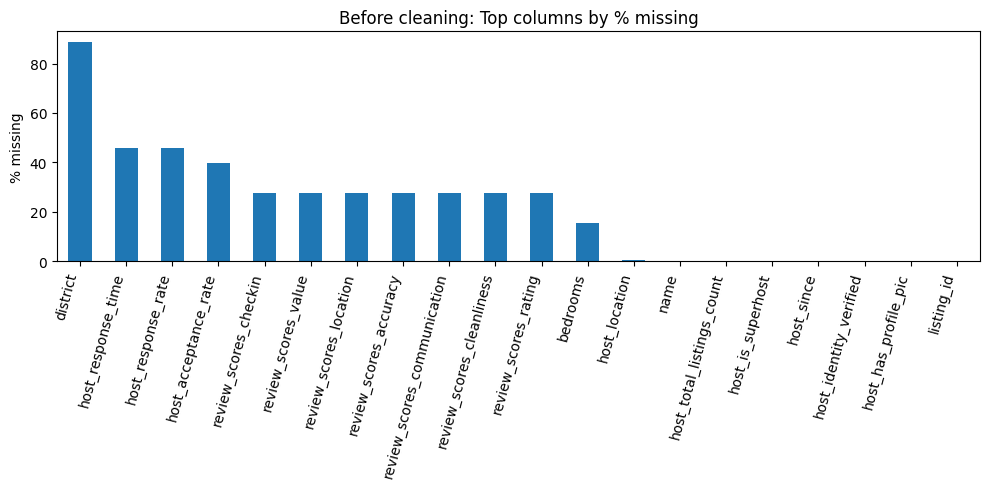

In [4]:
input_path = r"C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/Listings.csv"

output_workings = r"C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/listings_cleaned_with_workings.csv"
output_final    = r"C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/listings_final.csv"
output_log      = r"C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/cleaning_log.csv"

df = pd.read_csv(
    input_path,
    encoding="utf-8",
    encoding_errors="replace",
    low_memory=False,
)

print("Loaded:", df.shape)
plot_top_missing(df, top_n=20, title="Before cleaning: Top columns by % missing")


## Duplicate Detection

In [5]:
dupe_names = pd.Index(df.columns).duplicated()
if dupe_names.any():
    print("Duplicate column names detected:", df.columns[dupe_names].tolist())
else:
    print("No duplicate column names detected.")

identicals = find_identical_columns(df)
if identicals:
    print("Identical-content columns found (first 10):", identicals[:10])
else:
    print("No identical-content columns detected (within checked range).")


No duplicate column names detected.
No identical-content columns detected (within checked range).


## Cleaning Steps

In [6]:
# --- name cleanup ---
if "name" in df.columns:
    df["name_raw"] = df["name"].astype("string")
    df["name"] = df["name_raw"].map(fix_text_best)

    changed = df["name_raw"].fillna("").astype(str) != df["name"].astype("string").fillna("").astype(str)
    log_rule("name: fix mojibake + normalize", "name", changed.sum(),
             "ftfy + roundtrip + NFC + whitespace/control strip")

    still_bad = df["name"].astype("string").fillna("").str.contains(MOJIBAKE_MARKERS, na=False)
    log_rule("name: remaining mojibake markers", "name", still_bad.sum(),
             "Rows still matching mojibake marker regex (post-fix)")

    print("\nExamples of 'name' fixes:")
    show_changes(df, "name_raw", "name", n=15)

# --- host_since datetime ---
if "host_since" in df.columns:
    raw = df["host_since"].astype("string")
    parsed = pd.to_datetime(raw, errors="coerce")
    newly_invalid = raw.notna() & raw.ne("") & parsed.isna()
    df["host_since"] = parsed
    log_rule("host_since: to_datetime(coerce)", "host_since",
             newly_invalid.sum(), "Non-empty values that became NaT")

# --- categorical ---
if "host_response_time" in df.columns:
    before = df["host_response_time"].copy()
    df["host_response_time"] = df["host_response_time"].astype("category")
    affected = (before.astype("string").fillna("") != df["host_response_time"].astype("string").fillna("")).sum()
    log_rule("host_response_time: to category", "host_response_time",
             affected, "Converted dtype to category")

# --- booleans ---
bool_map = {
    "t": True, "f": False,
    "true": True, "false": False,
    "yes": True, "no": False,
    "y": True, "n": False,
}
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]
for col in [c for c in bool_cols if c in df.columns]:
    before = df[col].copy()
    df[col] = (
        df[col]
        .astype("string")
        .str.strip()
        .str.lower()
        .map(bool_map)
        .astype("boolean")
    )
    affected = (before.astype("string").fillna("") != df[col].astype("string").fillna("")).sum()
    log_rule(f"{col}: map to boolean", col, affected,
             "Converted common truthy/falsey strings to pandas boolean dtype")

# --- parse percent columns ---
for col in ["host_acceptance_rate", "host_response_rate"]:
    if col in df.columns:
        before = df[col].copy()
        df[col] = parse_percent_series(df[col])
        affected = (before.astype("string").fillna("") != df[col].astype("string").fillna("")).sum()
        log_rule(f"{col}: parse % to proportion", col, affected, "E.g. '95%' -> 0.95")

# --- bedrooms imputation ---
if "bedrooms" in df.columns and "property_type" in df.columns:
    before_na = df["bedrooms"].isna().sum()
    df["bedrooms"] = (
        df.groupby("property_type")["bedrooms"]
          .transform(lambda x: x.fillna(x.median()))
    )
    after_na = df["bedrooms"].isna().sum()
    log_rule("bedrooms: fill NA with median by property_type", "bedrooms",
             int(before_na - after_na), "Group-wise median imputation")

# --- reviews ---
review_cols = [c for c in df.columns if c.startswith("review_scores_")]

if "review_scores_rating" in df.columns:
    df["has_reviews"] = df["review_scores_rating"].notna().astype(int)
    log_rule("has_reviews: derived from review_scores_rating", "has_reviews",
             df["has_reviews"].sum(), "Count of listings with a rating")

if review_cols:
    before_na = int(df[review_cols].isna().sum().sum())
    df[review_cols] = df[review_cols].fillna(0)
    after_na = int(df[review_cols].isna().sum().sum())
    log_rule("review_scores_*: fill NA with 0", "review_scores_*",
             int(before_na - after_na), "Filled all review_scores_* missing values")

# --- amenities features ---
if "amenities" in df.columns:
    df["amenities_clean"] = (
        df["amenities"]
        .astype("string")
        .str.replace("{", "", regex=False)
        .str.replace("}", "", regex=False)
        .str.replace('"', "", regex=False)
        .str.lower()
    )
    log_rule("amenities_clean: derived from amenities", "amenities_clean",
             df["amenities_clean"].notna().sum(), "Removed braces/quotes + lowercased")

    s = df["amenities_clean"].fillna("").astype("string")
    df["amenities_count"] = (s.str.count(",") + (s != "")).astype("int64")
    log_rule("amenities_count: count amenities", "amenities_count",
             df["amenities_count"].notna().sum(), "Counted comma-separated items (NA -> 0)")

    df["has_wifi"] = df["amenities_clean"].str.contains("wifi", na=False)
    log_rule("has_wifi: derived flag", "has_wifi",
             df["has_wifi"].sum(), "amenities_clean contains 'wifi'")


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip


C:\Users\steve\AppData\Local\Temp\ipykernel_27888\2970423891.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  still_bad = df["name"].astype("string").fillna("").str.contains(MOJIBAKE_MARKERS, na=False)


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...



Examples of 'name' fixes:


,name_raw,name
27070,Executive Apt with terrific view !!,Executive Apt with terrific view !!
69107,ä¼ ç»Ÿæ³°å¼ç”Ÿæ´»ï¼Œæ—¶å°šä¸Žä¼ ç»Ÿçš„ç»“åˆã€‚,"传统泰式生活,时尚与传统的结合。"
20874,Appart 2 piÃ¨ces (40m2),Appart 2 pièces (40m2)
62231,Luxury Studio Bastille BAIL MOBILITÃ‰ POSSIBLE,Luxury Studio Bastille BAIL MOBILITÉ POSSIBLE
45355,HEART OF SÄ°SLÄ° WÄ°TH JAKUZÄ°,HEART OF SİSLİ WİTH JAKUZİ
48936,206376 - Appartement 5 personnes Ã Paris,206376 - Appartement 5 personnes à Paris
12735,CHARMING SOUPLEX APARTMENT - BONNE NOUVELLE D...,CHARMING SOUPLEX APARTMENT - BONNE NOUVELLE DI...
73939,VÃ­sta Mar e Montanha Totalmente Livre,Vísta Mar e Montanha Totalmente Livre
47909,Centrico y Amplio Loft Cerca del Ãngel / SmartTV,Centrico y Amplio Loft Cerca del Ángel / SmartTV
38783,sukhumvit Rd/1BR BTS zero meters new Luxury c...,sukhumvit Rd/1BR BTS zero meters new Luxury condo


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


C:\Users\steve\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\steve\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\steve\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\steve\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


,rule,column,rows_affected,notes
0,name: fix mojibake + normalize,name,14137,ftfy + roundtrip + NFC + whitespace/control strip
1,name: remaining mojibake markers,name,3,Rows still matching mojibake marker regex (pos...
2,host_since: to_datetime(coerce),host_since,48160,Non-empty values that became NaT
3,host_response_time: to category,host_response_time,0,Converted dtype to category
4,host_is_superhost: map to boolean,host_is_superhost,79948,Converted common truthy/falsey strings to pand...
5,host_has_profile_pic: map to boolean,host_has_profile_pic,79948,Converted common truthy/falsey strings to pand...
6,host_identity_verified: map to boolean,host_identity_verified,79948,Converted common truthy/falsey strings to pand...
7,instant_bookable: map to boolean,instant_bookable,80000,Converted common truthy/falsey strings to pand...
8,host_acceptance_rate: parse % to proportion,host_acceptance_rate,45405,E.g. '95%' -> 0.95
9,host_response_rate: parse % to proportion,host_response_rate,41023,E.g. '95%' -> 0.95


## Final Checks + Visuals


Shape after cleaning: (80000, 37)

Top 10 columns by remaining missing values:
host_since                   48212
host_response_rate           36590
host_response_time           36590
host_acceptance_rate         31633
host_location                  236
name                            68
name_raw                        68
host_total_listings_count       52
host_has_profile_pic            52
host_identity_verified          52
dtype: int64

Updated dtypes (first 15 columns):
listing_id                            int64
name                                 object
host_id                               int64
host_since                   datetime64[ns]
host_location                        object
host_response_time                 category
host_response_rate                  Float64
host_acceptance_rate                Float64
host_is_superhost                   boolean
host_total_listings_count           float64
host_has_profile_pic                boolean
host_identity_verified              b

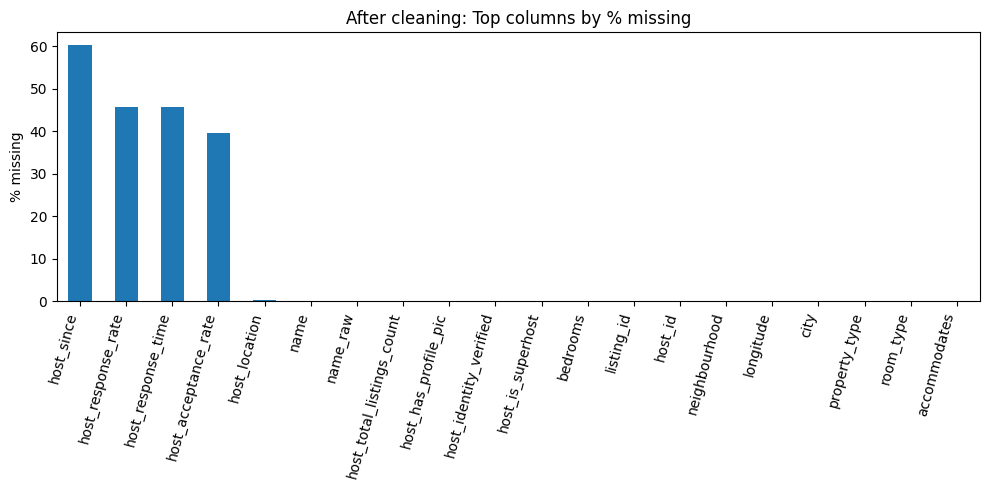

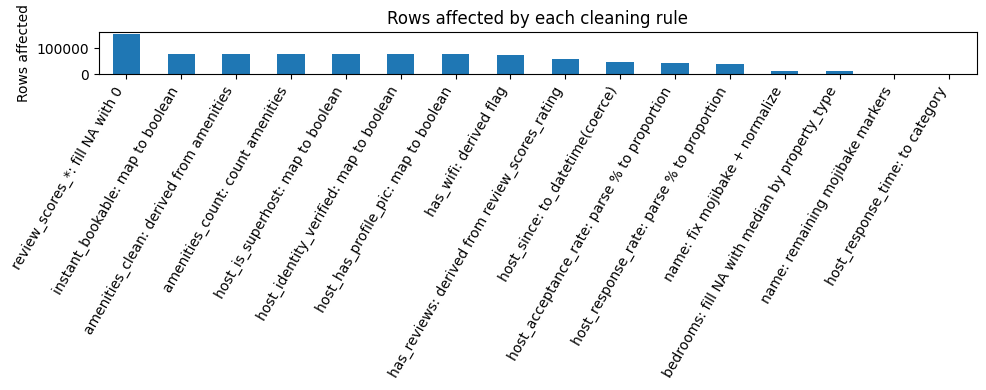

,column,dtype,missing,missing_%,unique
2,host_since,datetime64[ns],48212,60.26500,1553
3,host_response_time,category,36590,45.73750,4
5,host_response_rate,Float64,36590,45.73750,83
4,host_acceptance_rate,Float64,31633,39.54125,99
0,name,object,68,0.08500,77333
1,name_raw,string,68,0.08500,77365
6,host_is_superhost,boolean,52,0.06500,2
7,host_has_profile_pic,boolean,52,0.06500,2
8,host_identity_verified,boolean,52,0.06500,2
10,bedrooms,float64,13,0.01625,15


In [7]:
df = df.drop(columns=["district"], errors="ignore")

print("\nShape after cleaning:", df.shape)

print("\nTop 10 columns by remaining missing values:")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nUpdated dtypes (first 15 columns):")
print(df.dtypes.head(15))

plot_top_missing(df, top_n=20, title="After cleaning: Top columns by % missing")
plot_rule_counts(rule_counts, title="Rows affected by each cleaning rule")

edited_cols = [
    "name", "name_raw",
    "host_since", "host_response_time",
    "host_acceptance_rate", "host_response_rate",
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable",
    "bedrooms", "property_type",
    "amenities", "amenities_clean", "amenities_count", "has_wifi",
]
display(column_profile(df, edited_cols))


## Save Outputs

In [8]:
CTRL = re.compile(r"[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]")

text_cols = df.select_dtypes(include=["object", "string"]).columns
for c in text_cols:
    df[c] = (
        df[c]
        .astype("string")
        .map(lambda x: re.sub(CTRL, "", x) if x is not pd.NA else pd.NA)
    )

# 1) Audit/workings output
df.to_csv(output_workings, index=False, encoding="utf-8-sig")
print("\nSaved audit/workings data to:", output_workings)

# 2) Final output
WORKING_ONLY_COLS = ["name_raw", "name_clean", "amenities_clean"]
df_final = df.drop(columns=WORKING_ONLY_COLS, errors="ignore")

dropped = [c for c in WORKING_ONLY_COLS if c in df.columns]
print("Dropping from final:", dropped)
print("Workings shape:", df.shape, "| Final shape:", df_final.shape)

df_final.to_csv(output_final, index=False, encoding="utf-8-sig")
print("Saved final cleaned data to:", output_final)

# 3) Cleaning log
pd.DataFrame(clean_log).to_csv(output_log, index=False, encoding="utf-8-sig")
print("Saved cleaning log to:", output_log)



Saved audit/workings data to: C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/listings_cleaned_with_workings.csv
Dropping from final: ['name_raw', 'amenities_clean']
Workings shape: (80000, 37) | Final shape: (80000, 35)
Saved final cleaned data to: C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/listings_final.csv
Saved cleaning log to: C:/Users/steve/documents/portfolio-2025/python/project_01_data_cleaning/Data/cleaning_log.csv
